<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/2_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Feature importance - deciphering ML’s predictions

Tired of hearing people criticise ML algorithms for their black box nature? In this workshop we present three different ways to estimate the importance of the input features on the model outputs, enabling a better interpretation of our results: impurity feature importance, permutation feature importance and shap feature importance.

## 2.1 Setting up our RF model

### Model training and evaluation

To begin estimating feature importance we need a model. We will use the same model as in the previous [*Understanding Random Forest*](../1_understanding_random_forest.ipynb) workshop. Surprise, surprise, it's a Random Forest model. The task was to predict the water level at the Hagestein station using a selection of five meteorological and hydrological variables: the discharge of the Rhine (QRHINE) and Meuse (QMEUSE) at the Dutch border, the water level of the North Sea (WLHv), precipitation (RH) and evaporation (EV24). For more information about the data sources, we encourage you to check [Hauswirth et al. (2021)](https://doi.org/10.1016/j.advwatres.2021.104017).

The code blocks below (1) loads the data, (2) splits our data into training and testing datasets, (3) trains our random forest model and (4) provides a simple evaluation of the model performance. This time we import the libraries as we need them. If you have any problems understanding what is happening you can take a look at our previous workshops.

In [1]:
import pandas as pd

# Load the data
data_url =  "https://raw.githubusercontent.com/Jignesh1594/CodeGeoworkshop_02_understanding_RF/master/data.csv"
data = pd.read_csv(data_url, delimiter=",", on_bad_lines='skip')

# Select the input and output data
input_data = data[['WLHv', 'RH', 'EV24', 'QMeuse', 'QRhine']]
output_data = data['value']

# Display the first few rows of the data
input_data.join(output_data).head()

,WLHv,RH,EV24,QMeuse,QRhine,value
0,-18.395833,1.0,24.0,290.0,2579.0,269.72
1,-3.223881,177.0,23.0,167.0,1914.0,290.68
2,-13.020833,46.0,17.0,158.0,1864.0,289.52
3,2.618056,77.0,23.0,144.0,1777.0,287.88
4,5.812500,43.0,17.0,151.0,1759.0,290.92


In [2]:
import sklearn.model_selection as model_selection

# Split the data into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(input_data,
                                                                    output_data, 
                                                                    test_size=0.1,
                                                                    shuffle=False)

print(f"Train sample size is {X_train.index.size} and test sample size is {X_test.index.size}")

Train sample size is 11894 and test sample size is 1322


In [3]:
import sklearn.ensemble as ensemble

# Train the model
model = ensemble.RandomForestRegressor(random_state=42)
model.fit(X_train, y_train);

Mean Squared Error: 283.86055858294


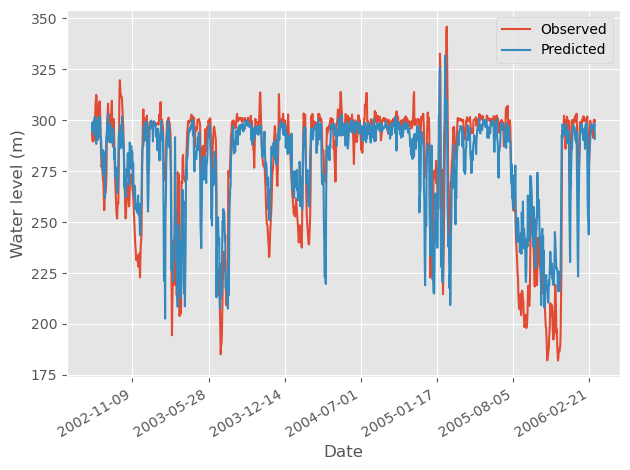

In [4]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates

# Set the style
style.use('ggplot')

# Evaluate the model MSE
y_pred = model.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

prediction = {"date": y_test.index,
              "Observed": y_test,
              "Predicted": y_pred}
prediction = pd.DataFrame(prediction)

# Plot the prediction
fig, ax = plt.subplots()
prediction.plot.line(x = "date", ax=ax)
ax.set_ylabel("Water level (m)")
ax.set_xlabel("Date")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
fig.tight_layout()

### Input features

It seems the model has a decent performance, but how is it doing those predictions? To that end we will investigate the importance of the input features for these prediction. Naturally, what is particularly important for this workshop is the input data for the Random Forest model. Here we use five inputs, called 'WLHv', 'RH', 'EV24', 'QMeuse', 'QRhine', that represent the north sea water level, rainfall, evaporation, discharge in the Meuse and discharge in the Rhine, respectively. The code below makes a quick plot of all the input data in the test dataset.

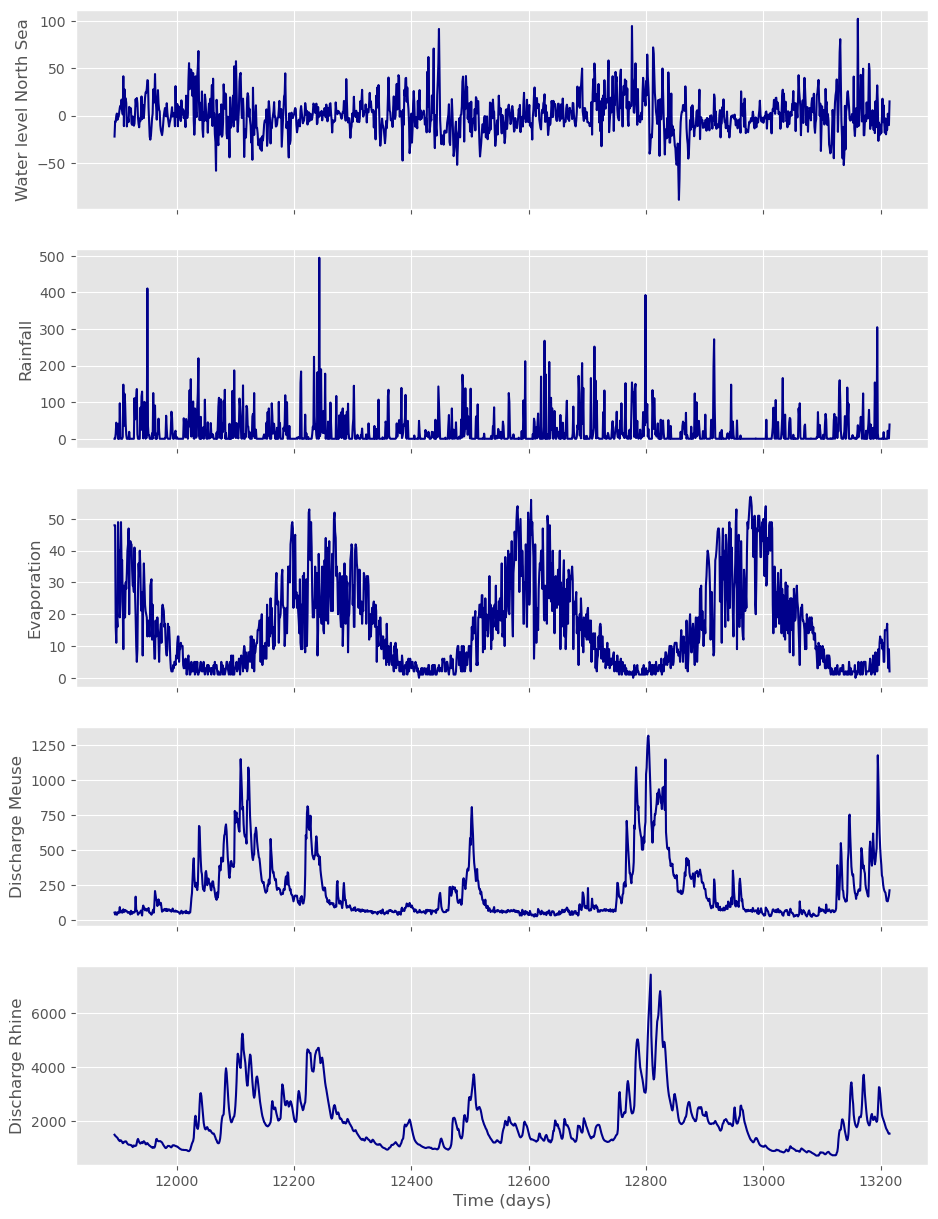

In [5]:
# Plot all columns of X_test
ax = X_test.plot(figsize=(11, len(X_test.columns)*3), color='darkblue',
                 y=['WLHv', 'RH', 'EV24', 'QMeuse',	'QRhine'],
                 subplots=True, sharex=True, xlabel="Time (days)", legend=False,)

# Add labels to the y-axes
ax[0].set_ylabel("Water level North Sea")
ax[1].set_ylabel("Rainfall")
ax[2].set_ylabel("Evaporation")
ax[3].set_ylabel("Discharge Meuse")
ax[4].set_ylabel("Discharge Rhine")

plt.show()

## 2.2 Impurity feature importance

### A bit of theory

Impurity feature importance is a special type of feature importance that is only available for random forest models and is sometimes called "gini importance" or "mean decrease impurity". This is the same as used in the previous workshop on [*Understanding Random Forests*](../1_understanding_random_forest.ipynb), but now we will try to understand it better. It is important to remember that random forests aggregate the results of multiple decision trees, which make their predictions by making binary decisions that split the data based on the input features.

Impurity feature importance measures how much each feature reduces the impurity in each of the decision tere nodes (or groups of data after a split). In regression tasks, impurity is often calculated as the variance of the output feature.

Here's how it works for a specific decision split:

1. When a node splits the data using a feature, creating two child nodes

2. The impurity (or variance in regression tasks) is calculated for the parent node.

3. The sum of the impurities (weighted by the proportion of samples) is calculated for the child nodes.

4. The impurity reduction is defined as the difference between 3. and 4.

The next step, is to sum all of the decreases in impurity in which a feature is involved for all the decision splits in all the trees. Those also need to be weighted by the proportion of samples reaching that specific node, so we account for the probability of reaching that node. We can then compare this score with the one obtained from other features to get a sense of which is more important, that is, most useful for improving prediction accuracy.

### Engage some braincells

Impurity feature importance is directly calculated by the sklearn package and stored in a property of the *RandomForestRegressor* class. Go to the [RandomForestRegressor documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), identify the property that stores the feature importance, and add it below by replacing `importance_property` in the first line. If today is not the day to engage your braincells, you can see the answer in the text below.

In [ ]:
# Obtain the feature importance
importances = model.importance_property # Replace with the correct property

# Visualize the results as a table
feature_importance = pd.DataFrame({"Feature": X_test.columns.to_list(),
                                   "Importance": importances.tolist()})
feature_importance

<details>
    <summary>Click to see the solution</summary>
    The feature importance property of the <i>RandomForestRegressor</i> class is <code>feature_importances_</code>
</details>

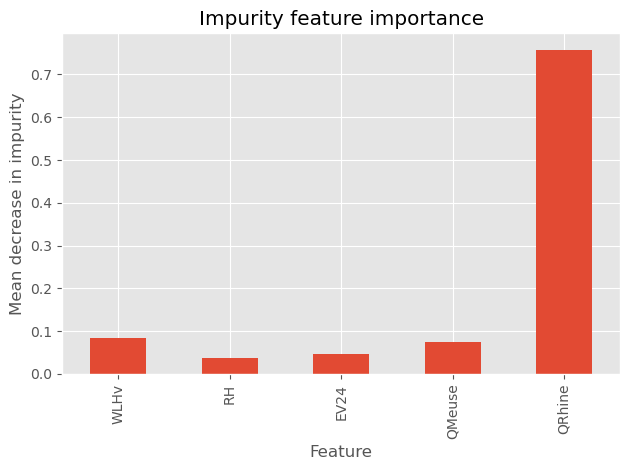

In [ ]:
# Plot the feature importance
fig, ax = plt.subplots()
feature_importance.plot.bar(x = "Feature",
                            y = "Importance",
                            ax=ax, legend=False)
ax.set_title("Impurity feature importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

## 2.3 Permutation feature importance

### A bit of theory

Permutation feature importance is a more generalizable method that can be applied to any type of machine learning model (e.g. random forest, neural network, LSTM) to determine the feature importance. Permutation feature importance is defined as the decrease in a model score when a feature is changed in some way, that is by permuting them. The features are permuted one-at-a-time, keeping the rest the same. For each of the feature permutations, we predict the new model outputs and compare them the original model ones using some metric. The change in such metric is the score that we assign to each feature to compare their importance.

We will try four different types of changes in the variable features to assess their importance. The first three types perform a **single value** impact analysis by eliminating the signal of a specific input feature completely. This can be achieved by setting all of the feature values to the minimum, mean and maximum of its distribution. The fourth type is the proper **permutation** impact analysis, which aims to introduce a lot of noise to the signal of the input feature by shuffling the data points around.

To get an idea of how to do that in practice, let's see two of the examples mentioned before, the mean and permutation importances. Before we get to the importances themselves though, let's see how each of those change how an input variable looks, for example the discharge at the Rhine station.

We can use the pandas `mean` and `sample` methods to easily transform our data, and then plot it with *matplotlib* as usual.

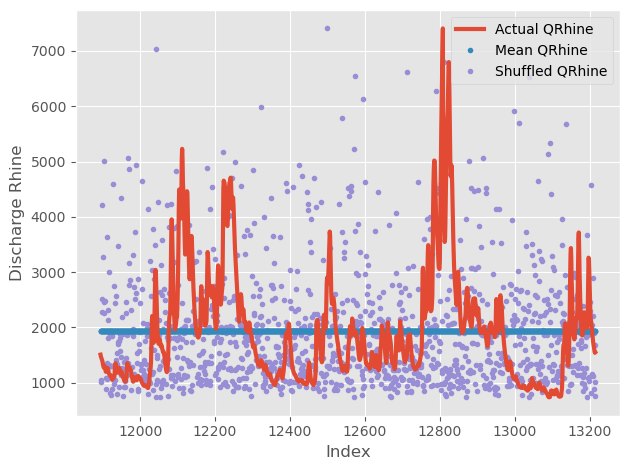

In [ ]:
import numpy as np

# Get the test data for the QRhine feature
actual_QRhine = X_test['QRhine']

# Take the mean of the QRhine feature and create a series
mean_QRhine_value = actual_QRhine.mean()
mean_QRhine = pd.Series(mean_QRhine_value, index=actual_QRhine.index)


# Shuffle the QRhine feature (and its indices)
shuffled_QRhine = actual_QRhine.sample(frac=1, random_state=42)
shuffled_QRhine.index = np.random.permutation(shuffled_QRhine.index)

# Plot the actual, mean and shuffled QRhine features
fig, ax = plt.subplots()
actual_QRhine.plot(ax=ax, label="Actual QRhine", linewidth=3, zorder=3)
mean_QRhine.plot(ax=ax, label="Mean QRhine", style='.', zorder=2)
shuffled_QRhine.plot(ax=ax, label="Shuffled QRhine", style='.', zorder=1)
ax.set_ylabel("Discharge Rhine")
ax.set_xlabel("Index")
ax.legend()
fig.tight_layout()
plt.show()

### Engage some braincells

Let's assess the difference between the original model outputs and the outputs obtained from a model with the mean-substituted values, in this case using the mean squared error (MSE) metric.

In [ ]:
import sklearn.metrics as metrics

# Crate a dictionary to store the results for each feature
mean_importance = {"feature": [],
                   "importance": []}

# Calculate mean premutation importance for each feature
for input_feature in X_test.columns:
    
    # Take the mean of the input feature and replace the original feature with it
    X_test_permuted = X_test.copy()
    X_test_permuted[input_feature] = X_test_permuted[input_feature].mean()
    
    # Evaluate the model predictions with the permuted feature
    y_pred_permuted = model.predict(X_test_permuted)
    mse_permuted = metrics.mean_squared_error(y_pred, y_pred_permuted)
    
    # Store the results in the dictionary
    mean_importance["feature"].append(input_feature)
    mean_importance["importance"].append(mse_permuted)
    print(f'Permutation (mean) importance of {input_feature}: {mse_permuted}')
    

Permutation (mean) importance of WLHv: 21.707866650952177
Permutation (mean) importance of RH: 9.196770525048358
Permutation (mean) importance of EV24: 24.394988567747134
Permutation (mean) importance of QMeuse: 21.37974625210605
Permutation (mean) importance of QRhine: 908.4530449012992


Now that you have seen how to calculate the mean permutation feature importance, you can do the same for the minimum, maximum and shuffle feature importance in the three code blocks below. Just copy the above code and adjust where necessary. Make sure you register the importance information to the correct dictionary: *minimum_importance*, *maximum_importance* and *shuffle_importance* respectively. A quick tip is to take a look at the [DataFrame sample function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) for the shuffle importance. If today is not the day to engage your braincells, you can see the answer in the text below.

In [ ]:
minimum_importance = {"feature": [],
                      "importance": [],}

In [ ]:
maximum_importance = {"feature": [],
                      "importance": [],}

In [ ]:
shuffle_importance = {"feature": [],
                      "importance": [],}

<details>
  <summary>Click to see the minimum solution</summary>
  <pre><code style="font-size: 14px;">
  
  \# Create a dictionary to store the results for each feature
  minimum_importance = {"feature": [], "importance": []}

  \# Calculate mean premutation importance for each feature
  for input_feature in X_test.columns:
      
      # Take the mean of the input feature and replace the original feature with it
      X_test_permuted = X_test.copy()
      X_test_permuted[input_feature] = X_test_permuted[input_feature].min()
      
      # Evaluate the model predictions with the permuted feature
      y_pred_permuted = model.predict(X_test_permuted)
      mse_permuted = metrics.mean_squared_error(y_pred, y_pred_permuted)
      
      # Store the results in the dictionary
      minimum_importance["feature"].append(input_feature)
      minimum_importance["importance"].append(mse_permuted)
      print(f'Permutation (minimum) importance of {input_feature}: {mse_permuted}')
  </code></pre>
</details>

<details>
  <summary>Click to see the maximum solution</summary>
  <pre><code style="font-size: 14px;">
  
  \# Create a dictionary to store the results for each feature
  maximum_importance = {"feature": [], "importance": []}

  \# Calculate mean permutation importance for each feature
  for input_feature in X_test.columns:
      
      # Take the max of the input feature and replace the original feature with it
      X_test_permuted = X_test.copy()
      X_test_permuted[input_feature] = X_test_permuted[input_feature].max()
      
      # Evaluate the model predictions with the permuted feature
      y_pred_permuted = model.predict(X_test_permuted)
      mse_permuted = metrics.mean_squared_error(y_pred, y_pred_permuted)
      
      # Store the results in the dictionary
      maximum_importance["feature"].append(input_feature)
      maximum_importance["importance"].append(mse_permuted)
      print(f'Permutation (maximum) importance of {input_feature}: {mse_permuted}')
  </code></pre>
</details>

<details>
  <summary>Click to see the shuffle solution</summary>
  <pre><code style="font-size: 14px;">
  
  \# Create a dictionary to store the results for each feature
  shuffle_importance = {"feature": [], "importance": []}

  \# Calculate mean permutation importance for each feature
  for input_feature in X_test.columns:
      
      # Shuffle the input feature and replace the original feature with it
      X_test_shuffled = X_test.copy()
      X_test_shuffled[input_feature] = X_test_shuffled[input_feature].sample(frac=1).values
      
      # Evaluate the model predictions with the shuffled feature
      y_pred_shuffled = model.predict(X_test_shuffled)
      mse_shuffled = metrics.mean_squared_error(y_pred, y_pred_shuffled)
      
      # Store the results in the dictionary
      shuffle_importance["feature"].append(input_feature)
      shuffle_importance["importance"].append(mse_shuffled)
      print(f'Permutation (shuffle) importance of {input_feature}: {mse_shuffled}')
  </code></pre>
</details>

Now that we obtained the importances using the four methods, we can make a plot to compare them. Make sure you have run all the four methods before trying to plot them.

In [ ]:
# Convert the importance dictionaries to a DataFrame
mean_importance = pd.DataFrame(mean_importance)
minimum_importance = pd.DataFrame(minimum_importance)
maximum_importance = pd.DataFrame(maximum_importance)
shuffle_importance = pd.DataFrame(shuffle_importance)

# Merge the DataFrames
permutation_importance = mean_importance[['feature']]
permutation_importance["mean"] = mean_importance['importance']
permutation_importance["minimum"] = minimum_importance['importance']
permutation_importance["maximum"] = maximum_importance['importance']
permutation_importance["shuffle"] = shuffle_importance['importance']

# Plot the feature importances
fig, ax = plt.subplots()
permutation_importance.plot.bar(x="feature",
                                ax=ax)
ax.set_title("Permutation feature importance")
ax.set_ylabel("Mean squared error")
fig.tight_layout()

## 2.4 SHAP importance

### A bit of theory

Lastly we take a look at SHAP importance values. The SHAP (SHapley Additive exPlanations) package is a popular Python library used for interpreting the output of machine learning models. It provides a unified framework for explaining the predictions made by black-box models. SHAP values, in particular, quantify the contribution of each feature to the prediction made by the model. They provide a measure of feature importance and help in understanding the impact of individual features on the model's output. Because SHAP values are very costly to compute, we usually rely on algorithms that approximate them (e.g., kernelSHAP, treeSHAP).

To use the SHAP package, we first need to install it, as it is not included in the Colab environment by default. Then, we need to build a SHAP explainer, the primary interface for the SHAP library. It takes our model and and returns a callable subclass object that implements the particular estimation algorithm that was chosen. From it, we can retrieve the feature importances of our model or use some of its plotting functions.

>Note: building the SHAP explainer may take some time! Expect around 5 min.

In [ ]:
%pip install shap   # Ignore if running locally

In [6]:
import shap

# Create an explainer object
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

 98%|===================| 1297/1322 [00:32<00:00]        

One of the unique features of SHAP values is that they can provide the *attribution* of the input features *for ever single prediction our model has made*. This means that they can tell us how the value that each of the input variables have for a specific data point stir the prediction to the right (positive) or left (negative) of the mean value of the predicted variable. 

We can visualize this extremely useful information using the [waterfall](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html) function. Let's go ahead and see how this plot looks for our first observation in the test set.

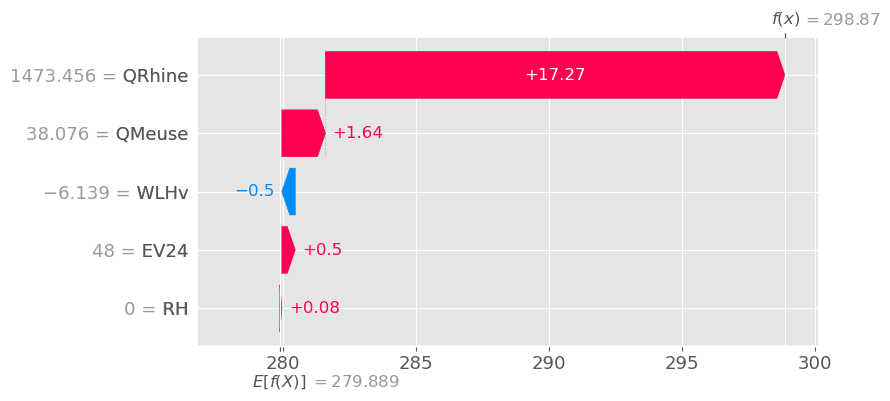

In [7]:
# Make a waterfall plot for the first data point
date_index = 1
shap.plots.waterfall(shap_values[date_index])

To read this type of plot, you start from the bottom, where the expected value (i.e., the mean) of the water level, our predicted variable, is represented. In our dataset, the mean is $E[f(X)] = 279.9 cm$. Starting from there, each input variable adds or substracts from it, until the final prediction $f(x) = 298.8 cm$ is reached. The positive contribution of most of the variables indicate that their values for this data point (indicated in the left axis) had an effect of increasing the water level compared to its mean value, except for the the sea level (WLHv), which reduces it instead. And we could do the same for any point of our dataset!

Another interesting plot can be displayed using the [beeswarm](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html) function. This plot also tries to show how the input variables impact the model's output, but in this case for the whole dataset provided to the explainer (```X_test``` in our case). This plot contains a lot of information so let's break it down.

Each data point in the test set, displayed as a dot in each of the features, is characterized by:

- X position: the SHAP value of that feature
- colour: the value of that feature
- wideness: the density of points for that SHAP value

Let's go ahead and take a look at how this plot looks for our data.



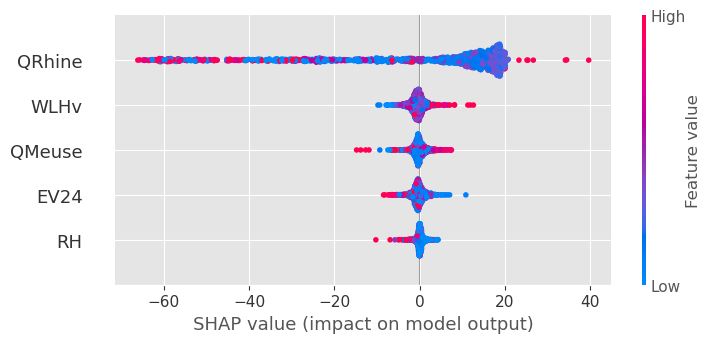

In [9]:
# Make a beeswarm plot
shap.plots.beeswarm(shap_values)

A lot of information can be extracted from this plot. For example, we can get an idea of how each of the input variables correlate with the output according to the model. For instance, the evaportranspiration (EV24) shows a negative correlation with the predicted water level, since for negative SHAP values the evaporation is high (represented in red) and for positive values it is low (represented in blue). This makes sense, as we would expect that the more evaporation there is, the smaller the water level will be. The opposite is true for the water level at the north sea (WLHv), which indicates a positive correlation.

This plot can also help us identify when the model is not behaving as expected. For example, it seems that the points that have the most negative impact in the predicted water level for both the Rhine (QRHINE) and Meuse (QMEUSE) correspond to high values of those features. Since we would expect the water level to raise when the discharge increases, this could indicate that the model has learnt some spurious correlations, or maybe that there are anomalies in the data used to train it.

### Engage some braincells

We have seen a lot of interesting features and plots about the SHAP library, but to compare it with the other methods we have seen we need to plot the importances for the input features in absolute values, not therir *attribution*. Go ahead and check how to do that in the [SHAP documentation](https://shap.readthedocs.io/en/latest/index.html) site, which we have also referred to for the previous plots. If today is not the day to engage your braincells, you can see the answer in the text below. 

In [ ]:
# Make a plot of the feature importances


<details>
    <summary>Click to see the solution</summary>
    The plot that returns the importance of all input features is the <a href="https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html">bar</a> plot, implemented with <code>shap.plots.bar(shap_values)</code>.
</details>